In [ ]:
# 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy.fftpack import fft, fftfreq
import scipy as sp


from scipy import signal

import umap
import umap.plot

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
freqmin = 1
freqmax = 8
sr = 40

reduce_type = np.mean

name_fig = 'figure07_comparision_umap'

name = f"final_version/{name_fig}"

savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name}/"

os.makedirs(savepath, exist_ok=True)



In [3]:


FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

vs = np.load(FILEPATH + 'vs_array.npy') 

data_s1 = np.hstack([np.load(FILEPATH + "z_r1.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r1.npy")[:, np.newaxis,:]] )
data_s2 = np.hstack([np.load(FILEPATH + "z_r2.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r2.npy")[:, np.newaxis,:]] )
data_s3 = np.hstack([np.load(FILEPATH + "z_r_s3.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s3.npy")[:, np.newaxis,:]] )
data_s4 = np.hstack([np.load(FILEPATH + "z_r_s4.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s4.npy")[:, np.newaxis,:]] )
data_s4_2 = np.hstack([np.load(FILEPATH + "new_data/z_r_s4_hor.npy")[:, np.newaxis,:], np.load(FILEPATH + "new_data/x_r_s4_hor.npy")[:, np.newaxis,:]] )

data_s5 = np.hstack([np.load(FILEPATH + "z_r_s5.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s5.npy")[:, np.newaxis,:]] )

# Concatenating the sources 
data = np.concatenate([ data_s4, data_s4_2], axis = 1) #+ 

# Filtering the data
#datafilter = filter(data[:, :], freqmin = freqmin, freqmax = freqmax, fs = 40, order = 2)



from scipy.signal import butter, sosfiltfilt

sos = butter(10, [freqmin, freqmax], 'bandpass', fs=sr, output='sos')
datafilter = sosfiltfilt(sos, data[:,:,:], axis=-1)


#datafilter = data[:, : ,:]#[:, np.newaxis, :]

#norm_two_channel  = np.sqrt(np.linalg.norm((data[:,:,:]), axis =2, keepdims=True)[:, 0, :]**2 + np.linalg.norm((data[:,:,:]), axis =2, keepdims=True)[:, 0, :]**2 )

# Normalizing the data

#data = datafilter

data = datafilter[:,:,::1]  / np.linalg.norm(abs(datafilter[:, :, :]), ord = 2, axis = -1, keepdims=True)
#data = datafilter[:,:,::1] / np.max(abs(datafilter[:, :, :]),  axis = -1, keepdims=True)

#data  = data[:,:,::1] = data/ np.max(abs(data))




In [4]:
# 

In [5]:
# 

In [6]:


from scatseisnet import ScatteringNetwork

segment_duration_seconds = data.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 5, "quality": 2, "taper_alpha" : 0.0},
    {"octaves": 4 , "resolution": 4, "quality": 3, "taper_alpha" : 0.0},
     )


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 8, "quality": 2, "taper_alpha" : 0.0},
    {"octaves": 5 , "resolution": 8, "quality": 3, "taper_alpha" : 0.0},
     )
     


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 8, "quality": 2},
    {"octaves": 6 , "resolution": 8, "quality": 3},
    )

    
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )



for i, bank in enumerate(network.banks):
    print(f"Bank {i}")
    print(bank)
    for j in range(bank.wavelets.shape[0]):
        network.banks[i].wavelets[j] = network.banks[i].wavelets[j] / np.sqrt((np.abs(network.banks[i].wavelets[j])**2).sum())

network.banks[0].spectra = np.fft.fft(network.banks[0].wavelets)
network.banks[1].spectra = np.fft.fft(network.banks[1].wavelets)


print(network)



Bank 0
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
Bank 1
ComplexMorletBank(bins=1500, octaves=6, resolution=8, quality=3, sampling_rate=40, len=48)
ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
ComplexMorletBank(bins=1500, octaves=6, resolution=8, quality=3, sampling_rate=40, len=48)


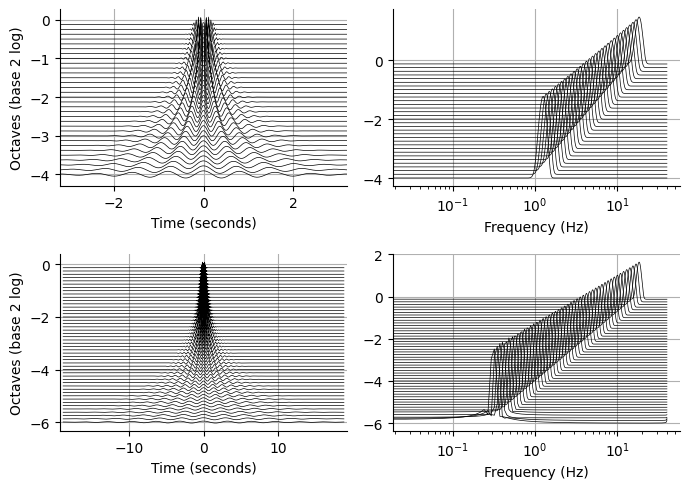

In [7]:

# Loop over network layers
#plt.figure(figsize=(10,5))

#cc = low_pass_filter(2000, sigma = 0.2)
fig, ax = plt.subplots(2, 2, figsize=(7,5),  )


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)
        #ax[i,0].plot(bank.times, wavelet.imag + ratio, c='r', lw = 0.5)

        # Spectral domain (log of amplitude)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)
        #ax[i,2].plot(bank.frequencies, np.log(np.abs(spectrum*cc[1000:]) + 1) + ratio, c = 'b', lw = 0.5)
        
    #ax[0,1].plot(bank.frequencies, np.log(np.abs(cc[1000:]) + 1) -0.25, c = 'r', lw = 0.5)

    # Limit view to three times the temporal width of largest wavelet
    width_max = 2 * bank.widths.max()

    # Labels
    
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    #ax[i, 0].set_xlim(0.1, 50)
    #  
    #ax[i,2].set_xscale("log")
    #ax[i,2].set_xlabel("Frequency (Hz)")
    #ax[i,2].grid()
    #ax[i, 1].set_xlim(0.1, 50)
    
    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    
fig.tight_layout()
#fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)


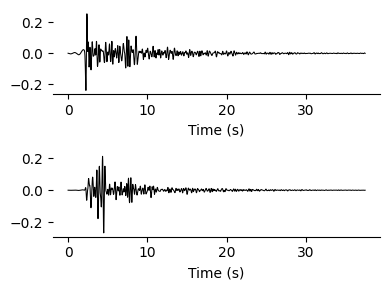

In [8]:

time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]


fig, axs = plt.subplots(2, 1, figsize = (4, 3))

axs[0].plot(time, data[indxvs[75, 30], 0, :].T,lw = 0.75, c = 'k')

axs[1].plot(time, data[indxvs[75, 30], 1, :].T,lw = 0.75, c = 'k')


ax = axs[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

ax = axs[1]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

fig.tight_layout()
#fig.savefig(savepath + f'seismograms.pdf', transparent=True)



In [9]:
# 


In [10]:
segments = [data[i,:,:] for i in indxvs[indx, 30]]


sc1 = network.transform(segments,  reduce_type= None )



In [11]:
# 

In [12]:
time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]



In [13]:

def reader_coeff(data):
    sc = [data['order_1'], data['order_2']]

    #sc = [scm2['order_1'], scm2['order_2']]
    for i in range(len(network.banks[0].centers)):
        
        # if network.banks[0].centers[i]>=10:

        #      sc[0][:,:, i] = np.nan
        #      sc[1][:,:, i,:] = np.nan

        n = network.banks[0].centers[i] <= network.banks[1].centers  # Find the center of the wavelet in the second layer that is closest to the center of the wavelet in the first layer
        sc[1][:,:, i, n] = np.nan
    
    return sc


from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.preprocessing import RobustScaler, MinMaxScaler



pooling = np.median


scm1 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_normalized_l2_wavelet_unnormalized'+ pooling.__name__+"horzontal"+ '.npz')

scm2 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_normalized_l2_wavelet_unnormalized'+ pooling.__name__ +'newdata'+ '.npz')




#scm2 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_unnormalized_wavelet_unnormalized.npz')
#scm3 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_normalized_wavelet_unnormalized_coda.npz')
#scm = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_max_normalized_l2_wavelet_unnormalized_median.npz')


#scm_unnorm = reader_coeff(scm2)
scm_norm_1 = reader_coeff(scm1)
scm_norm_2 = reader_coeff(scm2)



In [14]:

# scm_norm[1].shape

/tmp/ipykernel_792595/1040331069.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


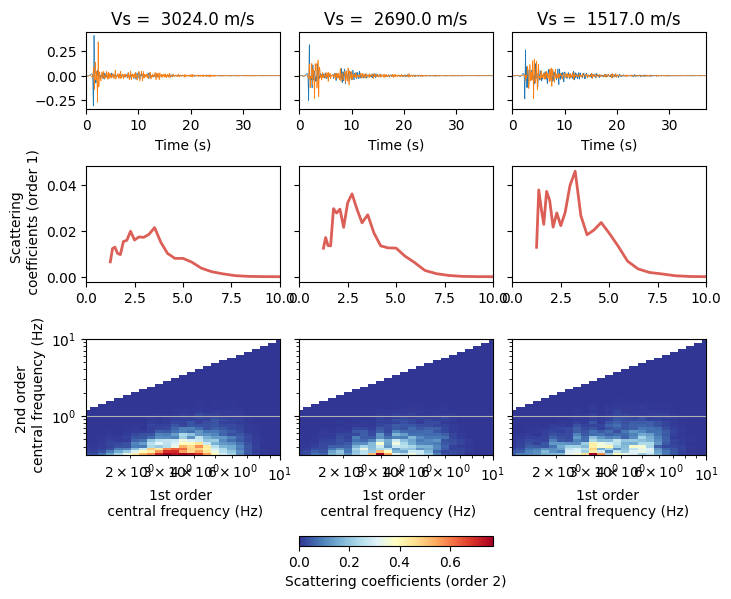

In [15]:
sc = scm_norm_1.copy()


gs = {"hspace": 0.4, "wspace": 0.1, "height_ratios": [1,1.5, 3]}
fig, axs = plt.subplots(
        3, 3, figsize=(8, 7), sharex="row", sharey="row", gridspec_kw=gs
    )

offset_x = 30

trc = [35, 55, 80]

ax = axs[0].reshape(-1)

for i, ind in enumerate(trc):

    ax[i].set_title(f"Vs =  {np.ceil(vs.reshape(-1)[indxvs[ind, offset_x]])} m/s")
    ax[i].plot(np.arange(len(data[0,0,:]))/40, data[indxvs[ind, offset_x],:2,:].T, lw = 0.5,)
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim(0, 37)

    
ax = axs[1].reshape(-1)


for i, ind in enumerate(trc):

    ax[i].plot(network.banks[0].centers, (sc[0][indxvs[ind, offset_x]][6]), lw = 2,  c = '#db5f57')

    #ax[i].plot(network.banks[0].centers, (sc2[0][indxvs[ind, offset_x]][0]), lw = 2,  c = 'k')

    #ax[i].set_xlabel('1st order \n frequency (Hz)')
    ax[i].set_xlim(0., 10)

ax[0].set_ylabel("Scattering \n coefficients (order 1)")
            
ax = axs[2].reshape(-1)

for i, ind in enumerate(trc):

    ss = (sc[1][indxvs[ind, offset_x]][6])
    #ss[np.isnan(ss)] = 0 
    
    img = ax[i].pcolormesh(network.banks[0].centers, network.banks[1].centers, (ss[:,:].T)**1,  vmin = 0,  cmap = 'RdYlBu_r', rasterized=True ) 
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[1].set_xlim(network.banks[0].centers.min(), 10)
    ax[1].set_ylim(network.banks[1].centers.min(), 10)

    ax[i].grid(True)

    ax[i].set_xlabel('1st order \n central frequency (Hz)')

    cb = plt.colorbar(img, ax=ax[i], orientation="horizontal", pad=0.35)
    cb.set_label("Scattering coefficients (order 2)")
    if i != 1:
        cb.ax.set_visible(False)


ax[0].set_ylabel('2nd order \n central frequency (Hz)')

fig.tight_layout()

#plt.savefig(savepath + "Coefficients" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



/tmp/ipykernel_792595/2466440423.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


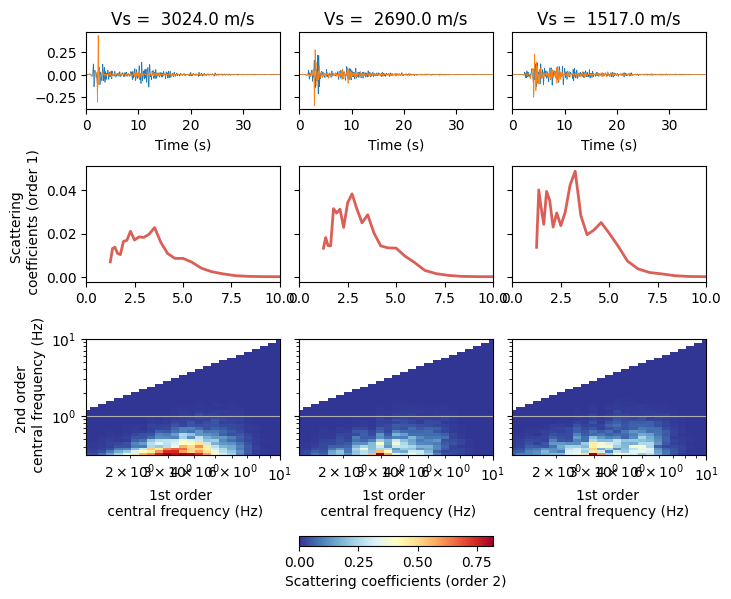

In [16]:
sc = scm_norm_2.copy()


gs = {"hspace": 0.4, "wspace": 0.1, "height_ratios": [1,1.5, 3]}
fig, axs = plt.subplots(
        3, 3, figsize=(8, 7), sharex="row", sharey="row", gridspec_kw=gs
    )


offset_x = 30

trc = [35, 55, 80]

ax = axs[0].reshape(-1)

for i, ind in enumerate(trc):

    ax[i].set_title(f"Vs =  {np.ceil(vs.reshape(-1)[indxvs[ind, offset_x]])} m/s")
    ax[i].plot(np.arange(len(data[0,2,:]))/40, data[indxvs[ind, offset_x],2:,:].T, lw = 0.5)
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim(0, 37)

    
ax = axs[1].reshape(-1)


for i, ind in enumerate(trc):

    ax[i].plot(network.banks[0].centers, (sc[0][indxvs[ind, offset_x]][6]), lw = 2,  c = '#db5f57')

    #ax[i].plot(network.banks[0].centers, (sc2[0][indxvs[ind, offset_x]][0]), lw = 2,  c = 'k')

    #ax[i].set_xlabel('1st order \n frequency (Hz)')
    ax[i].set_xlim(0., 10)

ax[0].set_ylabel("Scattering \n coefficients (order 1)")
            
ax = axs[2].reshape(-1)

for i, ind in enumerate(trc):

    ss = (sc[1][indxvs[ind, offset_x]][6])
    #ss[np.isnan(ss)] = 0 
    
    img = ax[i].pcolormesh(network.banks[0].centers, network.banks[1].centers, (ss[:,:].T)**1,  vmin = 0,  cmap = 'RdYlBu_r', rasterized=True ) 
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[1].set_xlim(network.banks[0].centers.min(), 10)
    ax[1].set_ylim(network.banks[1].centers.min(), 10)

    ax[i].grid(True)

    ax[i].set_xlabel('1st order \n central frequency (Hz)')

    cb = plt.colorbar(img, ax=ax[i], orientation="horizontal", pad=0.35)
    cb.set_label("Scattering coefficients (order 2)")
    if i != 1:
        cb.ax.set_visible(False)


ax[0].set_ylabel('2nd order \n central frequency (Hz)')

fig.tight_layout()

#plt.savefig(savepath + "Coefficients" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



In [17]:

def normalizing(scattering_coefficients, sil = 5):
    
    ss = scattering_coefficients.copy()
    
    c1 = ss[0].copy()
    c2 = ss[1].copy()

    c2hat = c2/ (np.nanmedian(c1, -1)+ sil )[:,:,np.newaxis , np.newaxis] 


    c2hat[np.isnan(scattering_coefficients[1])] == np.nan
    
    return [c1, c2hat]
    

In [18]:


from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize, PowerTransformer, QuantileTransformer, StandardScaler

hfreq = 0


def process__(scc, indx = None):
    
    sc = normalizing(scc, sil = np.mean(scc[0]) * 1)

    #sc = scc.copy()

    if indx == None:
        indx = np.arange(sc[0].shape[1])
        order_1 = sc[0][:, ::1, hfreq:]
        order_2 = sc[1][:, ::1, hfreq:, :]

    elif indx == 'avg':
        order_1 = np.nanmedian(sc[0][:, ::1, ::1], axis = 1)#[:, : , ::1]
        order_2 = np.nanmedian(sc[1][:, ::1, ::1, ::1], axis = 1)#[: , :, ::1, 10:]

    else:
        indx = indx
        order_1 = sc[0][:, indx, hfreq:]
        order_2 = sc[1][:, indx, hfreq:, :]

    #print(order_1)

    #scc = normalizing(sc, sil = 1e-1)

    order_1 = order_1.reshape(order_1.shape[0] , -1)
    order_2 = order_2.reshape(order_2.shape[0], -1)
    
    coeff =  np.hstack((order_1, order_2 ))
    
    coeff =  np.log((coeff[:, :]) + 1e-2)# * np.nanmax(coeff))

    coef = np.nan_to_num(coeff, 0)

    #coef = MinMaxScaler(feature_range = (-1, 1)).fit_transform(coef)

    coef  = RobustScaler().fit_transform(coef)
    
    # coef = QuantileTransformer(
    #         output_distribution="uniform", random_state=42
    #     ).fit_transform(coef)
    

    return coef

#scm_norm = reader_coeff(scm1)
#scm_unnorm = reader_coeff(scm2)
#scm_coda = reader_coeff(scm3)


In [24]:


def normalizing(scattering_coefficients, sil = 5):
    
    ss = scattering_coefficients.copy()
    
    c1 = ss[0].copy()
    c2 = ss[1].copy()

    c2hat = c2/ (np.nanmedian(c1, -1) + sil + 0* np.nanmax(c1, -1) )[:,:,np.newaxis , np.newaxis] 

    c2hat[np.isnan(scattering_coefficients[1])] == np.nan
    
    return [c1, c2hat]
    



from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize, PowerTransformer, QuantileTransformer, StandardScaler

hfreq = 0


def process__(scc, indx = None):
    
    #sc = normalizing(scc, sil = np.mean(scc[0]) * 1)

    sc = scc.copy()

    if indx == None:
        indx = np.arange(sc[0].shape[1])
        order_1 = sc[0][:, ::1, hfreq:]
        order_2 = sc[1][:, ::1, hfreq:, :]

    elif indx == 'avg':
        order_1 = np.nanmedian(sc[0][:, ::1, ::1], axis = 1)#[:, : , ::1]
        order_2 = np.nanmedian(sc[1][:, ::1, ::1, ::1], axis = 1)#[: , :, ::1, 10:]

    else:
        indx = indx
        order_1 = sc[0][:, indx, hfreq:]
        order_2 = sc[1][:, indx, hfreq:, :]

    #print(order_1)

    #scc = normalizing(sc, sil = 1e-1)

    order_1 = order_1.reshape(order_1.shape[0] , -1)
    order_2 = order_2.reshape(order_2.shape[0], -1)
    
    coeff =  np.hstack((order_1, order_2 ))
    
    coeff =  np.log((coeff[:, :]) + 1e-10)# * np.nanmax(coeff))

    coef = np.nan_to_num(coeff, 0)

    coef = MinMaxScaler(feature_range = (-1, 1)).fit_transform(coef)

    #coef  = RobustScaler().fit_transform(coef)
    
    # coef = QuantileTransformer(
    #         output_distribution="uniform", random_state=42
    #     ).fit_transform(coef)
    

    return coef
    
#scm_norm = reader_coeff(scm1)
#scm_unnorm = reader_coeff(scm2)
#scm_coda = reader_coeff(scm3)


In [25]:

from sklearn.decomposition import FastICA, PCA, KernelPCA, SparsePCA, IncrementalPCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans

from fastcluster import linkage
from scipy.cluster.hierarchy import fcluster
import umap
# explained_variance_score
from sklearn.metrics import explained_variance_score
from matplotlib import colors
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import explained_variance_score

import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable


def Reduceing(model, data, n):

    reducing_model = model(n_components= n , random_state = 0,)# max_iter= 1000, tol = 1e-20)
    features = reducing_model.fit_transform(data)
    iv  = reducing_model.inverse_transform(features)

    varaince = explained_variance_score(data, iv)

    return features, varaince

from string import ascii_uppercase
    
#dd = MinMaxScaler(feature_range = (-1, 1)).fit_transform()

def heir_cluster(features, threshold = 0.1, CLUSTERS = 5):
    
    linkage_matrix = linkage(features, "ward", metric = 'cityblock')
    
    # Find meta clusters

    clusters =  fcluster(linkage_matrix, CLUSTERS, criterion='maxclust')
    
    META_THRESHOLD = threshold * linkage_matrix[:, 2].max()

    meta_clusters  = fcluster(linkage_matrix, META_THRESHOLD, criterion="distance")
    
    cluster_indexes = np.arange(CLUSTERS) +1
    correspondance = np.zeros_like(cluster_indexes)
    for i, cluster in enumerate(cluster_indexes):
        correspondance[i] = np.unique(meta_clusters[clusters == cluster])[0]

    meta_clusters_labels, meta_clusters_counts = np.unique(
        correspondance, return_counts=True
    )
    labels = []
    for n in meta_clusters_counts:
        # If the cluster contains more than one sub-cluster, number them from 1 to n
        if n > 1:
            labels.extend(list(range(1, n + 1)))

        # If the cluster contains only one sub-cluster, leave it without number
        else:
            labels.append("")


    labels = [
        f"{ascii_uppercase[c - 1]}{l}" for c, l in zip(correspondance, labels)
    ]

    colors = []
    shift = 1
    for label in labels:
        if len(label) > 1:
            colors.append(f"C{ascii_uppercase.index(label[:1]) + shift}")
        else:
            shift -= 1
            colors.append("C0")

    return linkage_matrix, clusters, colors


from scipy.cluster.hierarchy import dendrogram
from matplotlib.colors import ListedColormap


def dendo(link, CLUSTERS, ax, threshold = 0.3):

    with plt.rc_context({"lines.linewidth": 1}):
        
        dendrogram(link ,
                CLUSTERS,
                orientation="top",
                truncate_mode="lastp",
                ax = ax,
                color_threshold= threshold * link[:, 2].max(),
                # above_threshold_color="k",
                no_labels=True,
            )
             


In [26]:

coef_1 = process__(scm_norm_1, indx = [6, 7])
#coef_avg = process__(scm_unnorm, indx = 'avg')
#coef_all = process__(scm_unnorm, indx = None)
coef_2 = process__(scm_norm_2, indx = [6, 7])

learning_rate = [1, 1, 1, 1]
model_umaps = []
umap_atlas = []

for i, coeff_ in enumerate([coef_1, coef_2]):
    
    umodel = umap.UMAP(densmap=False, 
        n_neighbors = 25,
        min_dist = 0.1,
        n_components = 2,
        random_state = 42,
        metric = 'manhattan',
        local_connectivity = 20,
        )


    u2 = umodel.fit_transform(
        coeff_[:,:],
        )
        
    model_umaps.append(umodel)
    umap_atlas.append(u2)

    print(i)
    

/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


1


/tmp/ipykernel_792595/3807918213.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  im = ax[i].scatter(umap_atlas[i][:, 0], umap_atlas[i][:, 1], c = 'k', vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max() , cmap = 'RdBu', s = 0.25, alpha = 0.25, rasterized=True)
/tmp/ipykernel_792595/3807918213.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


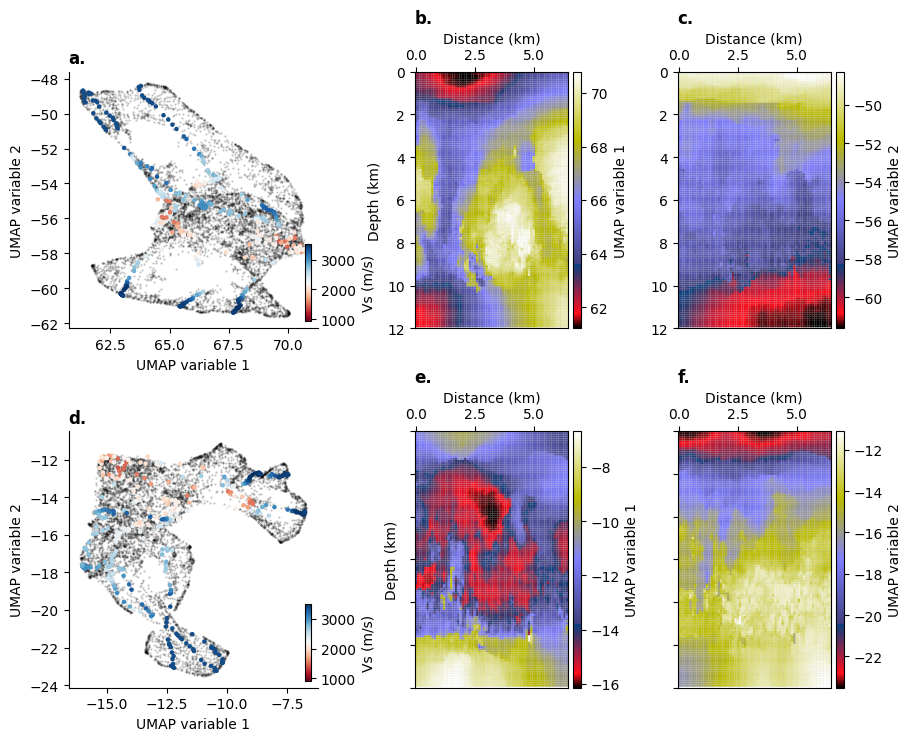

In [35]:

gs = {"hspace": 0.4, "wspace": 0.5, "width_ratios": [3,2, 2]}
fig, axs = plt.subplots(
        2, 3, figsize=(10, 8),  gridspec_kw=gs,
        #constrained_layout=True
    )
    
axs = axs.T

tit = ['station R3', 'combined-seismograms']
tit_ind = ['a', 'd']

ax = axs[0]
selecteddata = [0, 1]

for i in selecteddata:
    
    im = ax[i].scatter(umap_atlas[i][:, 0], umap_atlas[i][:, 1], c = 'k', vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max() , cmap = 'RdBu', s = 0.25, alpha = 0.25, rasterized=True)
    im = ax[i].scatter(umap_atlas[i][indxvs[:, 15], 0], umap_atlas[i][indxvs[:, 15], 1], c = vs.reshape(-1)[indxvs[:, 15]], vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max() , cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)
    im = ax[i].scatter(umap_atlas[i][indxvs[:, 30], 0], umap_atlas[i][indxvs[:, 30], 1], c = vs.reshape(-1)[indxvs[:, 30]], vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max() , cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)
    im = ax[i].scatter(umap_atlas[i][indxvs[:, 45], 0], umap_atlas[i][indxvs[:, 45], 1], c = vs.reshape(-1)[indxvs[:, 45]], vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max() , cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)
    
    ax[i].set_xlabel('UMAP variable 1')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #ax[i].set_title('UMAP atlas for' + f'\n {tit[i]}')

    if i == 1 or i ==0:

        axins1 = inset_axes(
            ax[i],
            width="2.5%",  # width: 50% of parent_bbox width
            height="30%",  # height: 5%
            loc="lower right",
        )
        axins1.xaxis.set_ticks_position("bottom")
        fig.colorbar(im, cax=axins1, orientation="vertical", label = 'Vs (m/s)')

    ax[i].set_ylabel('UMAP variable 2')

tit_ind = ['b', 'c']

for i in selecteddata:
    ax = axs[1]
    
    im = ax[i].pcolor(np.arange(65)/10, np.arange(120)[::1]/10, umap_atlas[i][:, 0].reshape(120, 65), cmap = 'gist_stern',   edgecolors='k', linewidths=0.01, rasterized = True)
    #ax[i].vlines(1.5, 0, 12, lw = 1, color = 'k')
    #ax[i].vlines(3, 0, 12, lw = 1, color = 'k')
    #ax[i].vlines(4.5, 0, 12, lw = 1, color = 'k')

    ax[i].set_ylim(12, 0)

    divider = make_axes_locatable(ax[i])
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im, cax=cax1, orientation='vertical', label ='UMAP variable 1')

    #ax[i].set_xticklabels([])
    if i>0:
        ax[i].set_yticklabels([])

    #ax[i].set_title('UMAP 1')
    #ax[i].axis('off')
    
    ax[i].set_xlabel('Distance (km)')


    ax[i].xaxis.set_label_position('top') 
    ax[i].xaxis.tick_top()

    #ax[0].set_ylabel('Depth (km)')

    ax = axs[2]

    im = ax[i].pcolor(np.arange(65)/10, np.arange(120)[::1]/10, umap_atlas[i][:, 1].reshape(120, 65), cmap = 'gist_stern',  edgecolors='k', linewidths=0.01, rasterized = True)
    ax[i].set_ylim(12, 0)
    divider = make_axes_locatable(ax[i])
    cax1 = divider.append_axes('right', size='5%', pad=0.05, )
    cbar = plt.colorbar(im, cax=cax1, orientation='vertical', label ='UMAP variable 2')

    #ax[i].set_title('UMAP 2')
    if i>0:
        ax[i].set_yticklabels([])


    #ax[i].axis('off')
    
    ax[i].set_xlabel('Distance (km)')

    ax[i].xaxis.set_label_position('top') 
    ax[i].xaxis.tick_top()


tit_ind = ['a', 'b', 'c', 'd', 'e', 'f']

for i in range(6):
    axs.T.reshape(-1)[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")


axs[1][0].set_ylabel('Depth (km)')
axs[1][1].set_ylabel('Depth (km)')

fig.tight_layout()
fig.savefig(savepath + "UMAP_atlas" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [29]:

import sklearn.decomposition
import sklearn.cluster
import sklearn.neighbors
from umap.utils import submatrix, average_nn_distance

def _nhood_search(umap_object, nhood_size):
    if hasattr(umap_object, "_small_data") and umap_object._small_data:
        dmat = sklearn.metrics.pairwise_distances(umap_object._raw_data)
        indices = np.argpartition(dmat, nhood_size)[:, :nhood_size]
        dmat_shortened = submatrix(dmat, indices, nhood_size)
        indices_sorted = np.argsort(dmat_shortened)
        indices = submatrix(indices, indices_sorted, nhood_size)
        dists = submatrix(dmat_shortened, indices_sorted, nhood_size)
    else:
        rng_state = np.empty(3, dtype=np.int64)
        indices, dists = umap_object._knn_search_index.query(
            umap_object._raw_data,
            k=nhood_size,
        )
    return indices, dists


def calulate_local_dimenstion(model, data = None, n_neighbors = None, threshold = 0.7, n_comp = 3):

    if data == None:
        data = model._raw_data

    if n_neighbors == None:
        n_neighbors = model.n_neighbors

    highd_indices, highd_dists = model._knn_search_index.query(
        data,
        k=n_neighbors,
        )
    
    local_dim = np.empty(data.shape[0], dtype=np.int64)

    three_comp = np.empty([data.shape[0], n_comp], dtype=np.float64)

    for i in range(data.shape[0]):  
        d = data[highd_indices[i]]
        pca = sklearn.decomposition.PCA()  
        compdata = pca.fit_transform(d)

        local_dim[i] = np.where(np.cumsum(pca.explained_variance_ratio_) > threshold)[0][0]
        three_comp[i,:] = compdata[0, :n_comp]
        
    return local_dim, three_comp


In [30]:

loc_dim = []
threecom2_main = []
for i , umodel in enumerate(model_umaps):

    local_dims, threecomp = calulate_local_dimenstion(umodel, threshold = 0.8)

    loc_dim.append(local_dims)
    threecom2_main.append(threecomp)

    print(i)

0
1


In [31]:
ss.min(), ss.max()

(nan, nan)

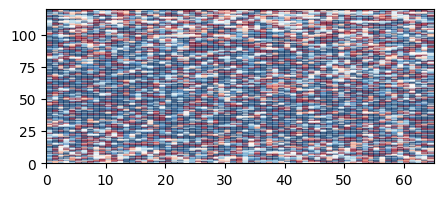

In [32]:
ss  = threecom2_main[1][:, 0] / (np.sum(threecom2_main[1], axis = 1) + 1e-10)

plt.figure(figsize=(5, 2))
plt.pcolor(ss.reshape(120, 65)[::-1, :], alpha = 0.5, cmap = 'RdBu', vmin = -2*np.median(ss), vmax = 2*np.median(ss))


/tmp/ipykernel_792595/947033856.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


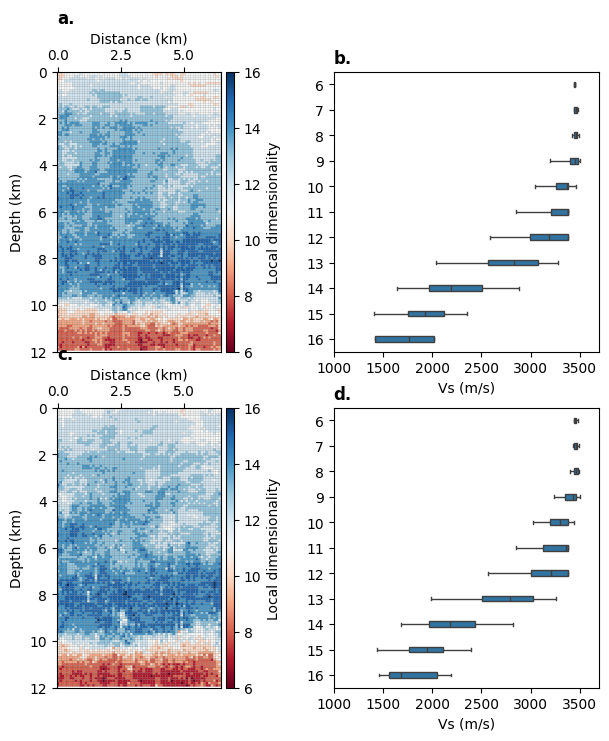

In [38]:

from mpl_toolkits.axes_grid1 import make_axes_locatable


gs = {"hspace": 0.2, "wspace": 0.45, "width_ratios": [2, 3]}
fig, axs = plt.subplots(
        2, 2, figsize=(7, 8),  gridspec_kw=gs,

    )


for i, d in enumerate(loc_dim):

    ax = axs[i]
    locdim = (d)# - np.min(d[2])) /  (np.max(d[2]) - np.min(d[2]))
    
    im1 = ax[0].pcolor(np.arange(65)/10, np.arange(120)[::1]/10, locdim.reshape(120, 65), cmap = 'RdBu',vmax = locdim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    ax[0].set_ylim(12, 0)

    divider = make_axes_locatable(ax[0])

    cax1 = divider.append_axes('right', size='5%', pad=0.05, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='vertical')
    cbar.set_label('Local dimensionality')
    
    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top()
    ax[0].set_xlabel('Distance (km)')
    ax[0].set_ylabel('Depth (km)')

    g = sns.boxplot(
        x= vs.reshape(-1), y= locdim, ax = ax[1], 
        whis=[5, 95], width = 0.25, gap=.1, orient = 'h',showfliers=False,
        )
    
    #ax[1].set_ylim(0.5, 4.5)
    #g.set_ylim(locdim.min()-0.5, locdim.max()+0.5)
    
    #ax[1].set_ylabel('Local dimensionality')
    ax[1].set_xlim(1000, 3700)
    ax[1].set_xlabel('Vs (m/s)')

titl = ['a', 'b', 'c', 'd']
for i in range(4):
    axs.reshape(-1)[i].set_title(f'{titl[i]}.', loc = 'left', fontsize = 12, fontweight="bold")
    
fig.tight_layout()
fig.savefig(savepath + "UMAP_dimensionality" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


In [39]:
def hilbet(sig, smooth = 10, order = 1):

    envelope = abs(sp.signal.hilbert(sig))
    return envelope# sp.signal.savgol_filter(envelope, smooth, order)




/tmp/ipykernel_792595/3027768091.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


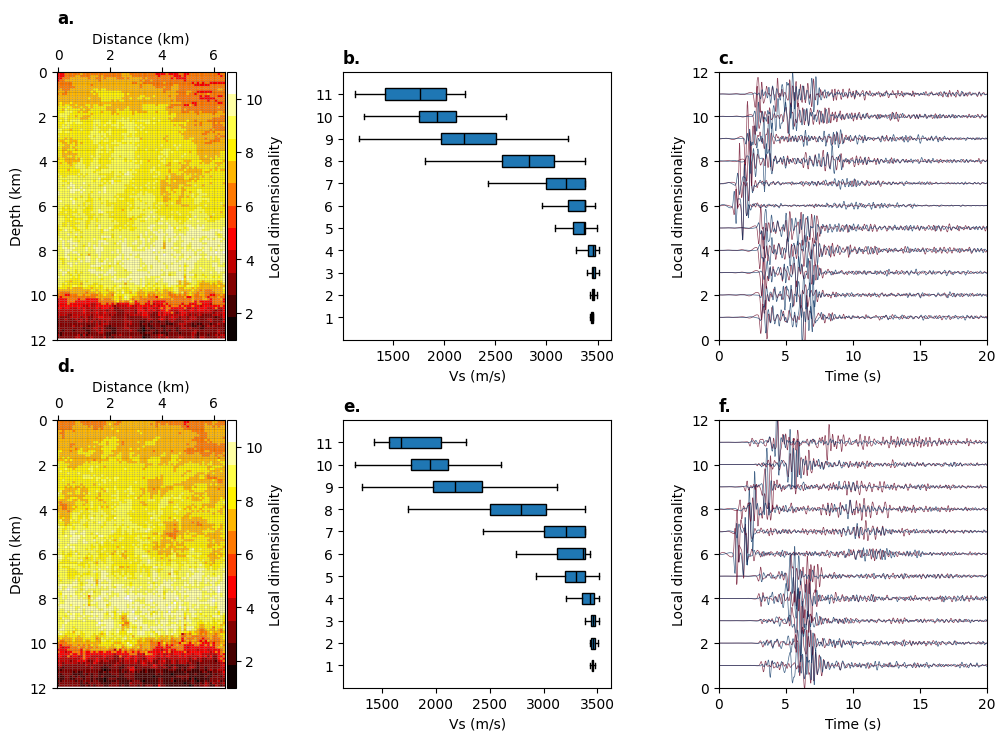

In [45]:
t = np.arange(data.shape[-1])/40


from mpl_toolkits.axes_grid1 import make_axes_locatable


gs = {"hspace": 0.3, "wspace": 0.45, "width_ratios": [2, 3, 3]}
fig, axs = plt.subplots(
        2, 3, figsize=(12, 8),  gridspec_kw=gs,

    )
    
ii  = [[0,1], [2, 3]]
for i_model, d in enumerate(loc_dim):

    ax = axs[i_model]
    locdim = (d)# - np.min(d[2])) /  (np.max(d[2]) - np.min(d[2]))
    locdim = locdim - locdim.min() + 1
    newcmap = plt.get_cmap('hot', len(np.unique(locdim))+1)

    im1 = ax[0].pcolor(np.arange(65)/10, np.arange(120)[::1]/10, locdim.reshape(120, 65), cmap = newcmap,  edgecolors='k', linewidths=0.05, rasterized = True)

    ax[0].set_ylim(12, 0)

    divider = make_axes_locatable(ax[0])
    cax1 = divider.append_axes('right', size='5%', pad=0.02, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='vertical')
    cbar.set_label('Local dimensionality')

    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top()
    ax[0].set_xlabel('Distance (km)')
    ax[0].set_ylabel('Depth (km)')

    dim = np.unique(locdim)

    for i, dimen in enumerate(dim[:]):

        indx = locdim == dimen

        vsselected = vs.reshape(-1)[indx]
        bplot = ax[1].boxplot(vsselected, 0, 'rs', 0, positions=[dimen], widths = 0.5, patch_artist = True, showfliers = False, medianprops=dict(color="black"))
        dd = data[np.where(indx)[0]][:, :, :]
        
        dd2 = hilbet(dd, smooth = 5, order = 1)
        dd2 = np.mean(dd2, 0)
        dd2 = np.mean(dd2, 0)

        dd2 = dd2[:, np.newaxis]* 5
        indsmean = np.argmin(abs(vsselected - np.median(vsselected)))
        dd = dd[indsmean][ ii[i_model],:]

        #dd = dd[:, 8, :]
        dd = dd.reshape(-1, 1500).T * 5

        #dd = np.mean(dd, 1, keepdims = True) 
        
        cmap2 = plt.get_cmap('RdBu', dd.shape[1])

        #[ax[2].plot(t, dd2[:, i] + dimen , c = 'r', lw = 0.75, alpha = 1, rasterized = True) for i in range(dd2.shape[1])]
        #[ax[2].plot(t, -dd2[:, i] + dimen , c = 'r', lw = 0.75, alpha = 1, rasterized = True ) for i in range(dd2.shape[1])]

        [ax[2].plot(t, dd[:, i] + dimen , c = cmap2(i), lw = 0.5, alpha = 0.75, rasterized = True) for i in range(dd.shape[1])]
        #[ax[2].plot(t, -dd[:, i] + dimen , c = cmap2(i), lw = 0.25, alpha = 0.5, rasterized = True ) for i in range(dd.shape[1])]
    
    ax[2].set_xlim(0, 20)
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Local dimensionality')

    ax[1].set_ylim(dim.min()-1, dim.max()+1)
    ax[2].set_ylim(dim.min()-1, dim.max()+1)
    
    ax[1].set_xlabel('Vs (m/s)')

titl = ['a', 'b', 'c', 'd', 'e', 'f']

for i in range(6):
    axs.reshape(-1)[i].set_title(f'{titl[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

fig.tight_layout()
fig.savefig(savepath + "UMAP_dimensionality_with_envelope" + ".png", bbox_inches="tight", dpi=300, transparent=True, )



In [59]:
#plt.pcolor(vs.reshape(120, 65)[100:,:][::-1, :])



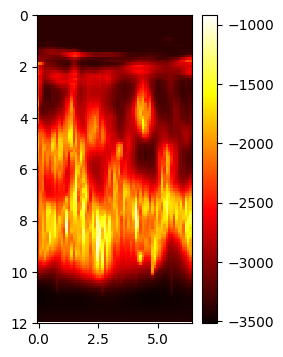

In [43]:
plt.figure(figsize = (2.5, 4))
plt.pcolor(np.arange(65)/10, np.arange(120)[::1]/10, -vs.reshape(120, 65), cmap = 'hot')
plt.ylim(12, 0)
plt.colorbar()

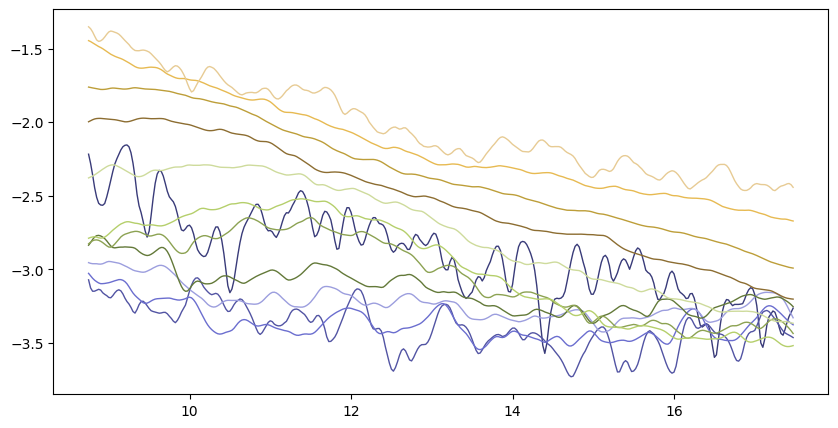

In [92]:

fig, axs = plt.subplots(1, 1, figsize = (10, 5))

dim = np.unique(loc_dim[1])

for ii, dimen in enumerate(dim):

    indx = loc_dim[1] == dimen

    vsselected = vs.reshape(-1)[indx]
    # bplot = ax.boxplot(vsselected, 0, 'rs', 0, positions=[dimen], widths = 0.5, patch_artist = True, showfliers = False, medianprops=dict(color="black"))

    ax = axs#[1]
    
    dd = data[np.where(indx)[0]][:, :, :]
        
    dd = hilbet(dd, smooth = 5, order = 1)
    
    dd = np.mean(dd, 1)

    #dd = dd[:, 4, :]
    
    dd2 = np.mean(dd, 0) *2

    dd = dd.reshape(-1, 1500).T * 2

    #dd = dd[:, :1]#/ np.max(abs(dd))
    
    dd = np.mean(dd, 1, keepdims = True)

    cmap2 = plt.get_cmap('tab20b', 20)


    [ax.plot(t[350 :700], np.log(dd[350 :700, i]) + ii/10 , c = cmap2(ii), lw = 1, alpha = 1 ) for i in range(dd.shape[1])]



In [87]:
# t[400]

In [88]:

# import seaborn as sns

# cmap2 = sns.color_palette("hls", 3)

# print(cmap2.as_hex())




In [40]:

# learning_rate = [1, 1, 5, 5]
# model_umaps_hyperpar = []
# umap_atlas_hyperpar = []

# n_neigh = [10 , 30, 50, ]

# min_dis = [0.1, 0.5, 0.9]

# for i, nn in enumerate(n_neigh):
#     mdl = []
#     atls = []
    
#     for j, dd in enumerate(min_dis):

#         umodel = umap.UMAP(densmap=False,
#                 n_neighbors = nn,
#                 min_dist = dd,
#                 n_components = 2,
#                 random_state = 42,
#                 metric = 'manhattan', 
#                 )
         
#         u2 = umodel.fit_transform(
#             coef_2[:,:],
#             )
        
#         mdl.append(umodel)
#         atls.append(u2)

#     print(i)

#     umap_atlas_hyperpar.append(atls)
#     model_umaps_hyperpar.append(mdl)
    

/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


1


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


In [41]:


loc_dim_hyperparmeter = []

varaince_threshold = [0.6, 0.75, 0.9]

for i in range(len(n_neigh)):

    varn = []
    for j, dd in enumerate(min_dis):

        fig, axs = plt.subplots(1, )

        local_dims = umap.plot.diagnostic(model_umaps_hyperpar[i][j], diagnostic_type='local_dim', ax = axs, local_variance_threshold=0.55)
        ax=fig.get_axes()[0]
        
        x_r=ax.collections[0].get_offsets()[:,0]
        y_r=ax.collections[0].get_offsets()[:,1]
        z_r=ax.collections[0].get_array()
        
        varn.append(z_r)
            
        plt.close(fig)

    loc_dim_hyperparmeter.append(varn)
    

/tmp/ipykernel_663275/1443902438.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im = axs[j, i].scatter(umap_atlas_hyperpar[i][j][:, 0], umap_atlas_hyperpar[i][j][:, 1], c = 'k', cmap = 'RdBu', s = 0.1, alpha = 0.75, rasterized=True)
/tmp/ipykernel_663275/1443902438.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


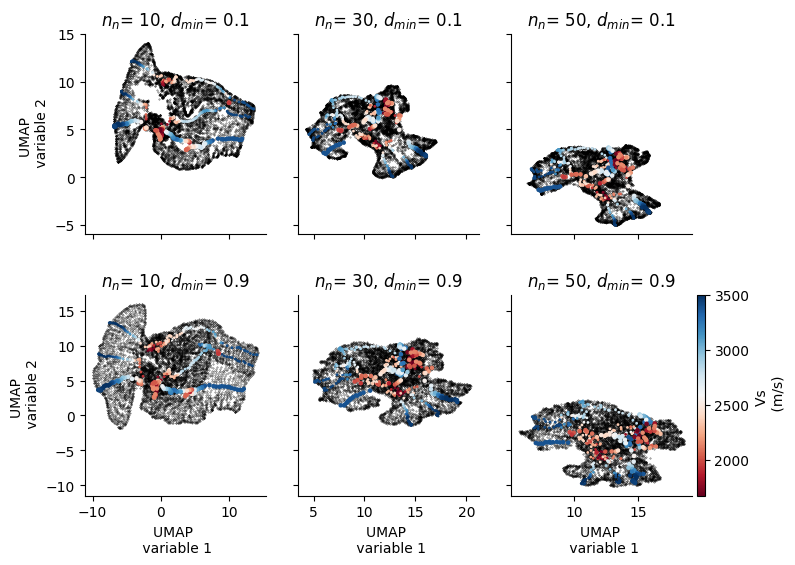

In [42]:

# gs = {"hspace": 0.3, "wspace": 0.1, "height_ratios": [3, 3]}
# fig, axs = plt.subplots(
#         2, 3, figsize=(8, 6),  gridspec_kw=gs, sharex = 'col', sharey = 'row',
#     )



# for i, nn in enumerate(n_neigh):
#     for j, dd in enumerate(min_dis[::2]):
#         #locdim = loc_dim_hyperparmeter[i][j]
#         #locdim = (locdim - np.min(locdim)) /  (np.max(locdim) - np.min(locdim))
#         im = axs[j, i].scatter(umap_atlas_hyperpar[i][j][:, 0], umap_atlas_hyperpar[i][j][:, 1], c = 'k', cmap = 'RdBu', s = 0.1, alpha = 0.75, rasterized=True)
#         im = axs[j, i].scatter(umap_atlas_hyperpar[i][j][indxvs[:, 15], 0], umap_atlas_hyperpar[i][j][indxvs[:, 15], 1], c = vs.reshape(-1)[indxvs[:, 15]], cmap = 'RdBu', s = 1, alpha = 1, rasterized=True)
#         im = axs[j, i].scatter(umap_atlas_hyperpar[i][j][indxvs[:, 30], 0], umap_atlas_hyperpar[i][j][indxvs[:, 30], 1], c = vs.reshape(-1)[indxvs[:, 30]], cmap = 'RdBu', s = 1, alpha = 1, rasterized=True)
#         im = axs[j, i].scatter(umap_atlas_hyperpar[i][j][indxvs[:, 45], 0], umap_atlas_hyperpar[i][j][indxvs[:, 45], 1], c = vs.reshape(-1)[indxvs[:, 45]], cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)

        
#         axs[j, i].set_title('$n_{n}$' +f'= {nn}, ' +  '$d_{min}$'+ f'= {dd}')
#         axs[j, i].spines['top'].set_visible(False)
#         axs[j, i].spines['right'].set_visible(False)
    

#         axs[1, i].set_xlabel('UMAP \n variable 1')
#         axs[j, 0].set_ylabel('UMAP \n variable 2')

#         if j == 1 and i == 2:
#             divider = make_axes_locatable(axs[j, i])
#             cax1 = divider.append_axes('right', size='4%', pad=0.05, )
#             cbar = plt.colorbar(im, cax=cax1, orientation='vertical', label = 'Vs \n (m/s)', aspect = 0.5)
#         else:

#             divider = make_axes_locatable(axs[j, i])
#             cax1 = divider.append_axes('right', size='4%', pad=0.05, )

#             cax1.axis('off')

# fig.tight_layout()
# fig.savefig(savepath + "UMAP_hyperparameters" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [43]:

# loc_dim_hyperparmeter = []
# varaince_threshold = [0.45, 0.7, 0.9]

# for i in range(len(n_neigh)):
#     varn = []

#     for j in range(3):
        
#         local_dims, threecomp = calulate_local_dimenstion(model_umaps_hyperpar[i][0], threshold = varaince_threshold[j])
#         varn.append(local_dims)

#     loc_dim_hyperparmeter.append(varn)
#     print(i)
    

0
1
2


In [ ]:
# 


/tmp/ipykernel_663275/838628510.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


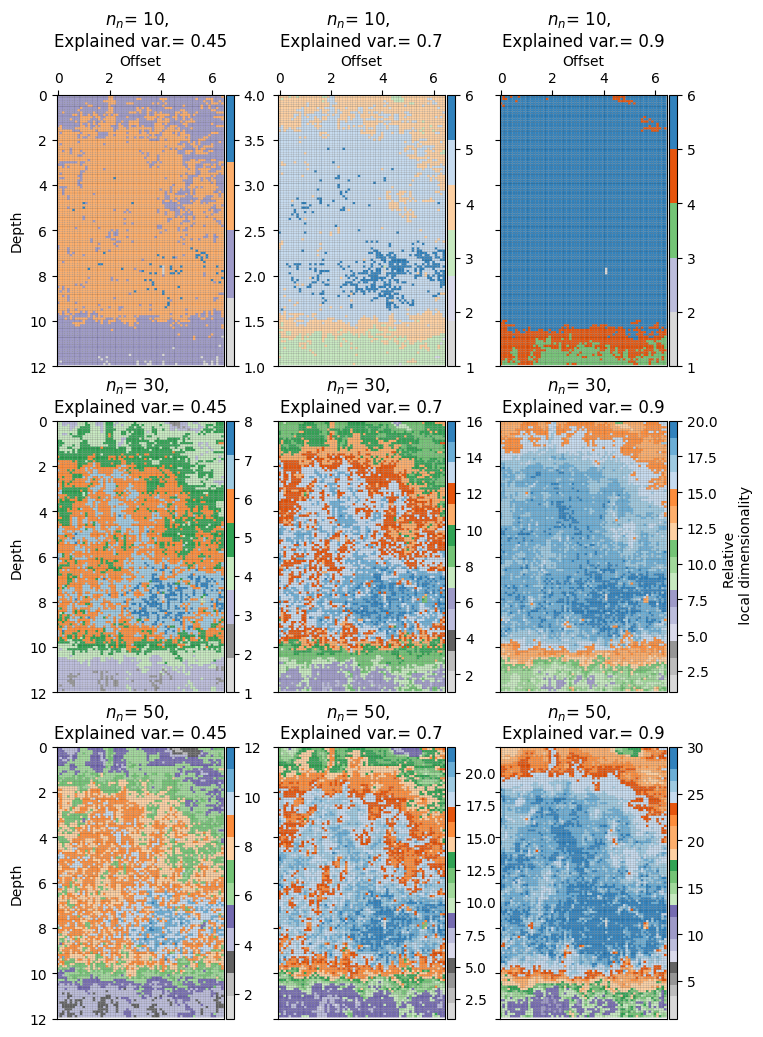

In [44]:

# gs = {"hspace": 0.2, "wspace": 0.25, "height_ratios": [3, 3, 3]}
# fig, axs = plt.subplots(
#         3, 3, figsize=(8, 12),  gridspec_kw=gs, sharey = 'row',
#     )


# vmax = np.max([i.max() for d in loc_dim_hyperparmeter for i in d])
# vmin = np.min([i.min() for d in loc_dim_hyperparmeter for i in d])

# for i, nn in enumerate(n_neigh):
#     for j, var in enumerate(varaince_threshold):
        
#         locdim = loc_dim_hyperparmeter[i][j]
#         locdim = locdim - locdim.min() + 1  
#         #locdim = (locdim - np.min(locdim)) /  (np.max(locdim) - np.min(locdim))

#         newcmap = plt.get_cmap('tab20c_r', len(np.unique(locdim)))

#         im = axs[i, j].pcolor(np.arange(65)/10, np.arange(120)[::1]/10, locdim.reshape(120, 65), cmap = newcmap, edgecolors='k', linewidths=0.05, rasterized = True)
#         axs[i, j].set_title('$n_{n}$' +f'= {nn}, ' +  ' \nExplained var.'+ f'= {var}')
#         #axs[i, j].spines['top'].set_visible(False)
#         #axs[i, j].spines['right'].set_visible(False)
#         axs[i, j].set_ylim(12, 0)

#         axs[0, j].set_xlabel('Offset')

#         axs[i, j].xaxis.set_label_position('top') 
#         axs[i, j].xaxis.tick_top()
#         #axs[i, j].xaxis.xticklabels([])
#         #axs[2, i].set_xlabel('Offset')
#         axs[i, 0].set_ylabel('Depth')

#         if i>0:
#             axs[i, j].set_xticks([])

#         #if j == 2 and i ==1:
        
#         divider = make_axes_locatable(axs[i, j])
#         cax1 = divider.append_axes('right', size='5%', pad=0.02, )
#         cbar = plt.colorbar(im, cax=cax1, orientation='vertical', aspect = 1)

#         if j == 2 and i == 1:
#             cbar.set_label('Relative \n local dimensionality')

# fig.tight_layout()

# fig.savefig(savepath + "UMAP_hyperparameters_dimensionality" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



(12.0, 0.0)

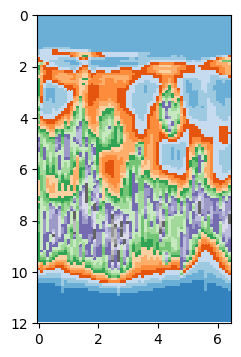

In [45]:

# # data = np.asarray([loc_dim_hyperparmeter[1][1], vs.reshape(-1)])
# plt.figure(figsize = (2.5, 4))
# plt.pcolor(np.arange(65)/10, np.arange(120)[::1]/10, vs.reshape(120, 65), cmap = 'tab20c_r')
# plt.ylim(12, 0)

In [46]:
# import seaborn as sns
# import pandas as pd

# df = pd.DataFrame(data.T, columns = ['loc', 'vs']


SyntaxError: incomplete input (2564943913.py, line 4)

NameError: name 'df' is not defined

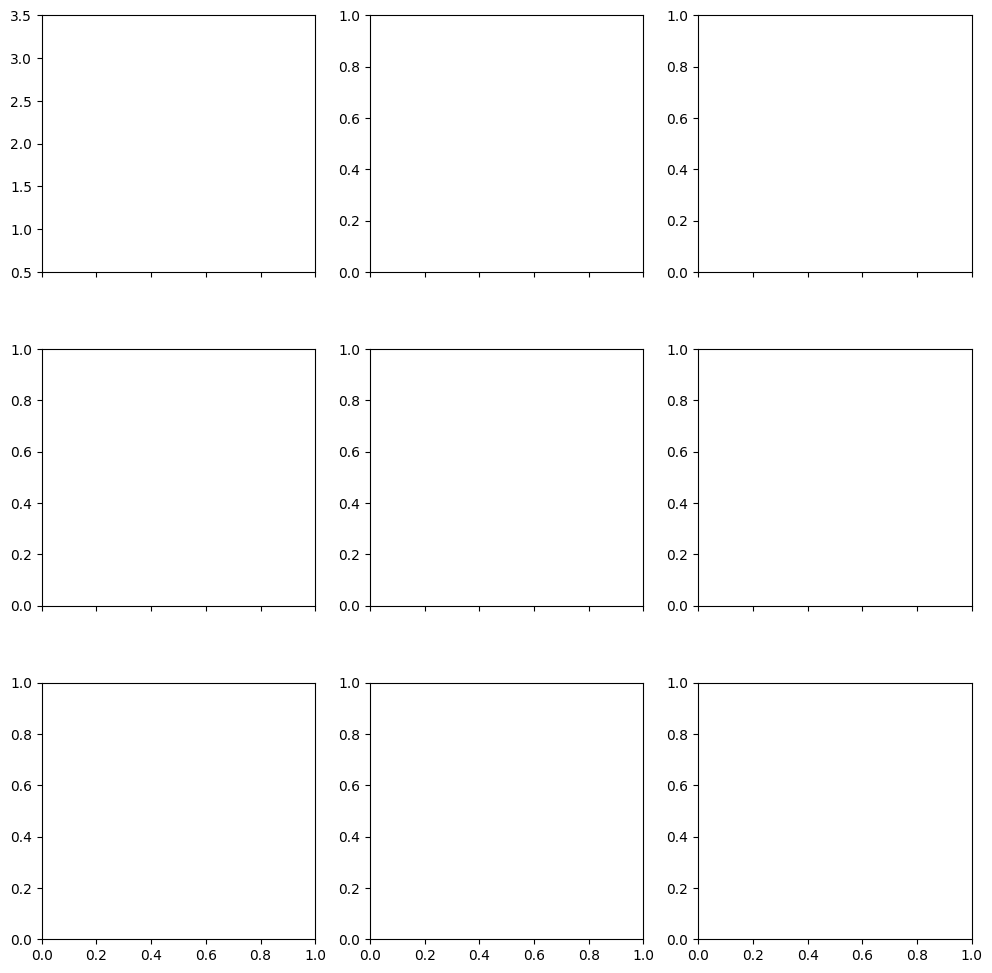

In [146]:
# gs = {"hspace": 0.3, "wspace": 0.2 }

# fig, axs = plt.subplots(
#         3, 3, figsize=(12, 12),  gridspec_kw=gs, sharex = True,
#     )


# for i, nn in enumerate(n_neigh):
#     for j, var in enumerate(varaince_threshold):
                
#         locdim = loc_dim_hyperparmeter[i][j]
#         locdim = (locdim)# - np.min(locdim)) /  (np.max(locdim) - np.min(locdim))

#         ax = axs[i, j]
#         ax.set_ylim([locdim.min() + 0.5, locdim.max()+0.5])

#         sns.boxplot(
#             data=df, x= vs.reshape(-1), y= locdim, orient = 'h',showfliers=False,
#             whis=[5, 95], width = 0.25, ax = ax, gap=.1

#         )

#         ax.set_title('$n_{n}$' +f'= {nn}, ' +  ' \nExplained var.'+ f'= {var}')
#         axs[i][j].set_xlim(1000, 3600)
#         axs[2][i].set_xlabel('Vs (m/s)')
#         #ax.set_ylim([locdim.min() + 0.5, loocdim.max()+0.5])


#     axs[i][0].set_ylabel('Local dimensionality')

    

# fig.tight_layout()

# fig.savefig(savepath + "UMAP_hyperparameters_dimensionality_vs" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)



In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [248]:
# x, y = np.ogrid[:vs.shape[0], :vs.shape[1]]
# x = x.squeeze()
# y = y.squeeze() 


# sh = 5

# vss =  np.zeros_like(vs)

# for i in x:
#     for j in y:
#         indd = j - sh 
#         indu = j + sh

#         indr = i + sh
#         indl = i - sh

#         if i <= sh:
#             indl = 0
#             indr = 2*sh

#         elif i >= vs.shape[0] - sh:
#             indl = vs.shape[0] - 2*sh
#             indr = vs.shape[0]

#         if j <= sh:
#             indd = 0
#             indu = 2*sh

#         elif j >= vs.shape[1] - sh:
#             indu = vs.shape[1] 
#             indd = vs.shape[1] - 2*sh

#         #vss[i, j] = np.nanmean(vs[indl:indr, indd : indu])

#         pca = PCA()
#         pca.fit_transform(coef_2[indxvs[indl:indr, indd: indu ].reshape(-1), : ])

#         vss[i,j] =len(np.where(np.cumsum(pca.explained_variance_ratio_)<.75)[0])
        
#     print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


/tmp/ipykernel_1033051/281645674.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


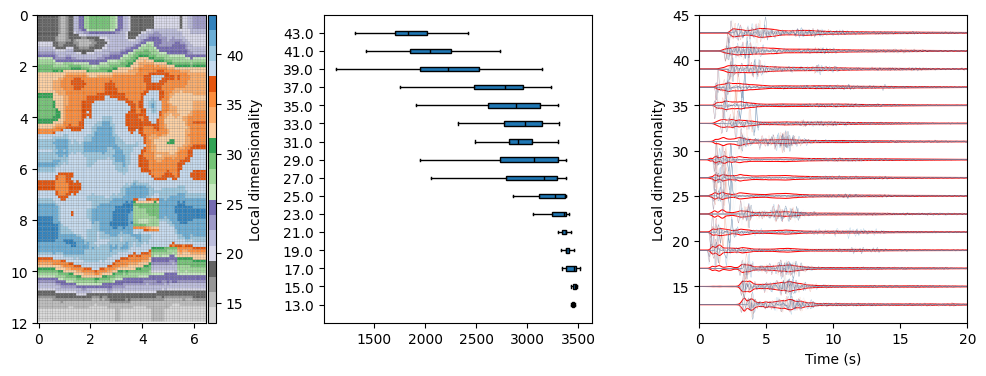

In [250]:


# gs = {"hspace": 0.3, "wspace": 0.45, "width_ratios": [2, 3, 3]}
# fig, ax = plt.subplots(
#         1, 3, figsize=(12, 4),  gridspec_kw=gs,

#     )




# im1 = ax[0].pcolor(np.arange(65)/10, np.arange(120)[::1]/10, vss, cmap = newcmap, edgecolors='k', linewidths=0.05, rasterized = True)

# ax[0].set_ylim(12, 0)

# divider = make_axes_locatable(ax[0])

# cax1 = divider.append_axes('right', size='5%', pad=0.02, )
# cbar = plt.colorbar(im1, cax=cax1, orientation='vertical')
# cbar.set_label('Local dimensionality')

# locdim = vss.reshape(-1)

# dim = np.unique(locdim)

# for i, dimen in enumerate(dim[::2]):

#     indx = locdim == dimen
        
#     vsselected = vs.reshape(-1)[indx]

#     bplot = ax[1].boxplot(vsselected, 0, 'rs', 0, positions=[dimen], widths = 0.5, patch_artist = True, showfliers = False, medianprops=dict(color="black"))


#     dd = data[np.where(indx)[0]][:, :, :]
        
#     dd2 = hilbet(dd, smooth = 5, order = 1)

#     dd2 = np.mean(dd2, 0)

#     dd2 = np.mean(dd2, 0)
#     dd2 = dd2[:, np.newaxis]* 5
        
#     indsmean = np.argmin(abs(vsselected - np.median(vsselected)))
#     dd = dd[indsmean][ :,:]

#     #dd = dd[:, 8, :]
#     dd = dd.reshape(-1, 1500).T * 5

#     #dd = np.mean(dd, 1, keepdims = True) 
        
#     cmap2 = plt.get_cmap('RdBu', dd.shape[1])

#     [ax[2].plot(t, dd2[:, i] + dimen , c = 'r', lw = 0.75, alpha = 1, rasterized = True) for i in range(dd2.shape[1])]
#     [ax[2].plot(t, -dd2[:, i] + dimen , c = 'r', lw = 0.75, alpha = 1, rasterized = True ) for i in range(dd2.shape[1])]

#     [ax[2].plot(t, dd[:, i] + dimen , c = cmap2(i), lw = 0.25, alpha = 0.5, rasterized = True) for i in range(dd.shape[1])]
#     #[ax[2].plot(t, -dd[:, i] + dimen , c = cmap2(i), lw = 0.25, alpha = 0.5, rasterized = True ) for i in range(dd.shape[1])]
    
# ax[2].set_xlim(0, 20)
# ax[2].set_xlabel('Time (s)')
# ax[2].set_ylabel('Local dimensionality')

# ax[1].set_ylim(dim.min()-2, dim.max()+1)
# ax[2].set_ylim(dim.min()-2, dim.max()+1)

# fig.tight_layout()
# fig.savefig(savepath + "UMAP_dimensionality_with_envelope_in_velocity_model" + ".png", bbox_inches="tight", dpi=300, transparent=True, )



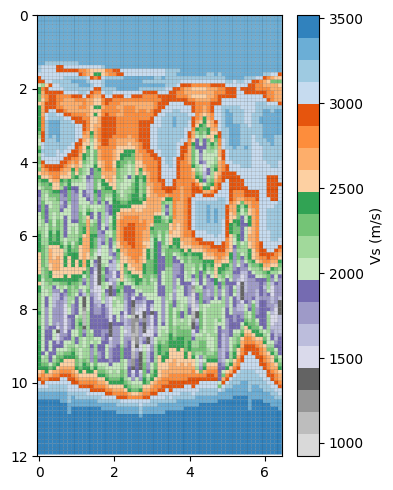

In [251]:
# plt.figure(figsize = (4, 5))
# plt.pcolor(np.arange(65)/10, np.arange(120)[::1]/10, vs.reshape(120, 65), cmap = 'tab20c_r', edgecolors='k', linewidths=0.05, rasterized = True)
# plt.ylim(12, 0)

# plt.colorbar(label = "Vs (m/s)")

# plt.tight_layout()
# plt.savefig(savepath + "real_model" + ".png", bbox_inches="tight", dpi=300, transparent=True, )



In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [ ]:
# 